In [1]:
#Connexion à la bdd
from py2neo import Graph, authenticate, Relationship
graph = Graph()
authenticate("localhost:7474","neo4j", "admin")

In [2]:
graph.schema.create_index(":character","name")

In [2]:
whole_graph_edges = graph.cypher.execute('''
    MATCH (c1:character)-[r:APPEARS_IN*2]-(c2:character)
    WITH c1,c2,COUNT(DISTINCT r) as nb_tar
    RETURN SUM(nb_tar);
''')[0][0]
print("Whole graph edges weight: %d" % whole_graph_edges)

Whole graph edges weight: 1139540


In [3]:
#coverage function
def coverage(df):
    edges = 0
    #pour chaque cluster
    for i in range(max(df["cluster"])+1):
        
        #on selectionne les noeuds de ce cluster
        node_list = df.Personnage[df["cluster"] == i]
        
        #on définie les paires en itérant sur la liste de noeuds
        for n1 in node_list:
            for n2 in node_list:
                result = graph.cypher.execute('''
                
                MATCH (c1:character {name:{char1}})-[r:APPEARS_IN*2]-(c2:character {name:{char2}})
                WITH c1,c2, COUNT(DISTINCT r) AS nb_tar
                WHERE c1.name <> c2.name
                RETURN SUM(nb_tar)
                
                ''', {"char1":n1, "char2":n2})[0][0]
                
                edges += result
    return(float(edges)/float(whole_graph_edges))

In [4]:
#extraction des paires et leur distance
pers_paires = graph.cypher.execute('''
    MATCH (c1:character)-[d:DISTANCE]->(c2:character)
    WITH c1,c2,d
    WHERE c1.name <> c2.name
    RETURN c1.name AS PERSONNAGE1, c2.name AS PERSONNAGE2, d.JACCARD AS DISTANCE;
''')
pers_paires[0]

 PERSONNAGE1          | PERSONNAGE2 | DISTANCE      
----------------------+-------------+----------------
 24-HOUR MAN/EMMANUEL | OLD SKULL   | 0.947368421053

In [5]:
#Creation de la liste de reference des personnages
pers = []
for pair in pers_paires:
    if pair[0] not in pers:
        pers.append(pair[0])
    if pair[1] not in pers:
        pers.append(pair[1])
pers[:5]

[u'24-HOUR MAN/EMMANUEL',
 u'OLD SKULL',
 u"G'RATH",
 u"M'SHULLA",
 u'3-D MAN/CHARLES CHAN']

In [6]:
#on stock les personnages dans une dataframe
import pandas as pd
pers_df = pd.DataFrame(pers, columns=["Personnage"])

In [7]:
#creation d'une matrice
import numpy as np
len_mat = len(pers)
mat = np.empty([len_mat,len_mat], dtype=float)
mat.fill(-100.0)

In [8]:
#remplissage de la matrice en suivant l'ordre des personnages de la df
for pair in pers_paires:
    mat[np.where(pers_df.Personnage == pair[0]), np.where(pers_df.Personnage == pair[1])] = -100 * pair[2]
mat[:4,:4] 

array([[-100.        ,  -94.73684211,   -0.        ,  -95.        ],
       [-100.        , -100.        ,  -94.73684211, -100.        ],
       [-100.        , -100.        , -100.        , -100.        ],
       [-100.        ,   -5.        ,  -95.        , -100.        ]])

In [9]:
#la distance d'un personnage avec lui-meme est 0
np.fill_diagonal(mat,0.0)

In [10]:
from sklearn.cluster import AffinityPropagation

#values for preference
mat_pref = np.median(mat)

mat_pref

-100.0

In [11]:
af = AffinityPropagation(preference = mat_pref, affinity = "precomputed")
af.fit(mat)

#stockage des labels des clusters pour chaque personnage
pers_df["cluster"] = af.labels_

#le coverage
coverage(pers_df)

0.106514909524896

In [12]:
len(af.cluster_centers_indices_)

1768

In [13]:
af.labels_

array([   1,    0,    1, ..., 1613, 1767, 1755], dtype=int64)

In [14]:
pers_df.head()

,Personnage,cluster
0,24-HOUR MAN/EMMANUEL,1
1,OLD SKULL,0
2,G'RATH,1
3,M'SHULLA,0
4,3-D MAN/CHARLES CHAN,4


In [25]:
len(pers_df.loc[pers_df.cluster ==1,:])

2

In [27]:
pers_per_cl = []
for i in range(1768):
    nb_pers = len(pers_df.loc[pers_df.cluster == i,:])
    pers_per_cl.append([i,nb_pers])
pers_per_cl

[[0, 6],
 [1, 2],
 [2, 9],
 [3, 8],
 [4, 5],
 [5, 5],
 [6, 8],
 [7, 9],
 [8, 10],
 [9, 5],
 [10, 3],
 [11, 6],
 [12, 5],
 [13, 13],
 [14, 7],
 [15, 5],
 [16, 7],
 [17, 5],
 [18, 7],
 [19, 6],
 [20, 8],
 [21, 17],
 [22, 3],
 [23, 5],
 [24, 8],
 [25, 5],
 [26, 6],
 [27, 4],
 [28, 4],
 [29, 6],
 [30, 12],
 [31, 3],
 [32, 3],
 [33, 3],
 [34, 4],
 [35, 2],
 [36, 5],
 [37, 4],
 [38, 6],
 [39, 5],
 [40, 3],
 [41, 5],
 [42, 9],
 [43, 4],
 [44, 6],
 [45, 10],
 [46, 5],
 [47, 13],
 [48, 3],
 [49, 4],
 [50, 4],
 [51, 5],
 [52, 5],
 [53, 11],
 [54, 3],
 [55, 4],
 [56, 15],
 [57, 4],
 [58, 4],
 [59, 4],
 [60, 4],
 [61, 5],
 [62, 13],
 [63, 5],
 [64, 11],
 [65, 5],
 [66, 3],
 [67, 3],
 [68, 6],
 [69, 5],
 [70, 4],
 [71, 5],
 [72, 4],
 [73, 15],
 [74, 5],
 [75, 4],
 [76, 4],
 [77, 7],
 [78, 7],
 [79, 7],
 [80, 5],
 [81, 5],
 [82, 8],
 [83, 3],
 [84, 4],
 [85, 3],
 [86, 4],
 [87, 6],
 [88, 9],
 [89, 6],
 [90, 5],
 [91, 5],
 [92, 13],
 [93, 3],
 [94, 7],
 [95, 4],
 [96, 3],
 [97, 10],
 [98, 2],
 [99, 4

In [28]:
cl_df = pd.DataFrame(pers_per_cl,columns=["cluster_nb","nb_pers"])

In [29]:
cl_df.head()

,cluster_nb,nb_pers
0,0,6
1,1,2
2,2,9
3,3,8
4,4,5


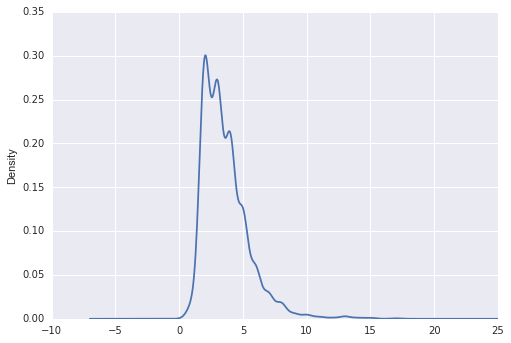

In [32]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
cl_df.nb_pers.plot.density()
plt.show()

In [33]:
cl_df.loc[cl_df.nb_pers == max(cl_df.nb_pers),:]

,cluster_nb,nb_pers
21,21,17


In [34]:
pers_df.loc[pers_df.cluster == 21,:]

,Personnage,cluster
69,"JAMESON, J. JONAH",21
277,"LEEDS, BETTY BRANT",21
425,"ROBERTSON, JOE",21
1762,"THOMPSON, EUGENE FLA",21
1798,"WATSON, ANNA",21
2153,"APPLEBAUM, PHANTASY",21
2933,"HARDY, LYDIA",21
3561,"BERNHARD, CLARICE",21
3636,VULTURE II/BLACKIE D,21
4481,FACADE,21
